In [16]:
import torch.nn as nn
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, random_split
import pickle
%matplotlib widget

In [3]:
from google.colab import drive
import os

drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/MyDrive/TH_CSE18_group_01/Datasets')

Mounted at /content/drive


## ConvLSTM

In [7]:
# from github.com/andyflying/lightnet_plus

class ConvLSTM2D(nn.Module):
    def __init__(self, channels, filters, kernel_size, img_rowcol):
        super(ConvLSTM2D, self).__init__()
        # self.channels = channels
        self.filters = filters
        self.padding = kernel_size // 2
        # self.kernel_size = kernel_size
        # self.strides = strides
        self.conv_x = nn.Conv2d(channels, filters * 4, kernel_size=kernel_size, stride=1, padding=self.padding, bias=True)
        self.conv_h = nn.Conv2d(filters, filters * 4, kernel_size=kernel_size, stride=1, padding=self.padding, bias=False)
        self.mul_c = nn.Parameter(torch.zeros([1, filters * 3, img_rowcol, img_rowcol], dtype=torch.float32))


    def forward(self, x, h, c):
        # x -> [batch_size, channels, x, y]
        x_concat = self.conv_x(x)
        h_concat = self.conv_h(h)
        i_x, f_x, c_x, o_x = torch.split(x_concat, self.filters, dim=1)
        i_h, f_h, c_h, o_h = torch.split(h_concat, self.filters, dim=1)
        i_c, f_c, o_c = torch.split(self.mul_c, self.filters, dim=1)
        i_t = torch.sigmoid(i_x + i_h + i_c * c)
        f_t = torch.sigmoid(f_x + f_h + f_c * c)
        c_t = torch.tanh(c_x + c_h)
        c_next = i_t * c_t + f_t * c
        o_t = torch.sigmoid(o_x + o_h + o_c * c_next)
        h_next = o_t * torch.tanh(c_next)
        return h_next, c_next

In [8]:
class LightNet(nn.Module):
    def __init__(self, obs_tra_frames, obs_channels):
        super(LightNet, self).__init__()
        self.obs_tra_frames = obs_tra_frames
        self.future_frames = 6
        mn = (159//2)//2
        self.obs_encoder_module = nn.Sequential(
            nn.Conv2d(obs_channels, 4*obs_channels, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(4*obs_channels, 4*obs_channels, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(4*obs_channels, 64, kernel_size=5, stride=1, padding=2),
            nn.LayerNorm([64, mn, mn], elementwise_affine=True)
        )
        self.encoder_ConvLSTM = ConvLSTM2D(64, 64, kernel_size=5, img_rowcol=mn)
        self.encoder_h = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=1, stride=1),
            nn.ReLU(),
        )
        self.encoder_c = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=1, stride=1),
            nn.ReLU(),
        )

        # self.decoder_ConvLSTM = ConvLSTM2D(8, 8, kernel_size=5, img_rowcol=mn)

        self.decoder_1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(8, 8, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(8, 16, kernel_size=5, stride=1, padding=2),
            nn.LayerNorm([16, mn, mn], elementwise_affine=True)
        )
        self.decoder_ConvLSTM = ConvLSTM2D(16, 64, kernel_size=5, img_rowcol=mn) # first on is the output channels channels of decoder_1 and second one is the hidden channels

        self.decoder_2 = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=5, stride=2, padding=2, output_padding=1), # 7 -> 5
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=8, stride=2, padding=2, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=1, stride=1)
        )

        # self.decoder_3 = nn.Sequential(
        #     nn.Conv2d(64, obs_channels, kernel_size=1, stride=1),
        #     nn.ReLU()
        # )

        # self.decoder_3 = nn.Sequential(
        #     nn.Conv2d(obs_channels, 1, kernel_size=1, stride=1),
        #     nn.ReLU()
        # )
        self.conv_fusion_h = nn.Conv2d(8, 8, kernel_size=5, stride=1, padding=2, groups=2)





    def forward(self, obs):
        # obs : [batch_size, frames, x, y, channels] -> [frames, batch_size, channels, x, y]
        # obs = obs.permute(1, 0, 2, 3, 4).contiguous()

        # [batch_size, frames, channels, x, y]


        batch_size = obs.shape[0]


        h = torch.zeros([batch_size, 64, (159//2)//2, (159//2)//2], dtype=torch.float32).to(obs.device)
        c = torch.zeros([batch_size, 64, (159//2)//2, (159//2)//2], dtype=torch.float32).to(obs.device)

        pre_frames = torch.zeros([batch_size, self.future_frames, 1, 159, 159], dtype=torch.float32)


        for t in range(self.obs_tra_frames):
            obs_encoder = self.obs_encoder_module(obs[:,t])
            h, c = self.encoder_ConvLSTM(obs_encoder, h, c)
        h = self.encoder_h(h)
        c = self.encoder_c(c)

        # print(h.shape)
        # print(c.shape)


        x = obs[:, -1, 0:1]
        # print("last frame shape", x.shape)
        for t in range(self.future_frames):
            x = self.decoder_1(x)
            # print("decoder_1 shape", x.shape)
            h, c = self.decoder_ConvLSTM(x, h, c)
            # print("decoder_ConvLSTM shape", h.shape, c.shape)
            x = self.decoder_2(c)
            # print("decoder_2 shape", x.shape)
            pre = x
            # print("decoder_3 shape", x.shape)
            # pre = self.decoder_4(x)
            # print("pre shape", pre.shape)
            pre_frames[:,t] = pre
            # x = pre

        # print(pre_frames.shape)
        return pre_frames



# score.py

In [9]:
import torch
import datetime
import os

class Cal_params_epoch(object):
    def __init__(self):
        # n1->TP  n2->FP  n3->FN  n4->TN
        self.n1 = 0
        self.n2 = 0
        self.n3 = 0
        self.n4 = 0
        self.n1sum = 0
        self.n2sum = 0
        self.n3sum = 0
        self.n4sum = 0
        self.eps = 1e-10

    def _transform_sum(self, y_true, y_pred):
        y_true = y_true.permute(1, 0, 2, 3, 4).cpu().contiguous()
        # y_true = y_true.permute(1, 0, 2, 3).cpu().contiguous()
        y_pred = y_pred.permute(1, 0, 2, 3, 4).cpu().contiguous()
        y_pred = torch.round(torch.sigmoid(y_pred))
        frames = y_true.shape[0]
        sum_true = torch.zeros(y_true[0].shape)
        sum_pred = torch.zeros(y_pred[0].shape)
        for i in range(frames):
            sum_true += y_true[i]
            sum_pred += y_pred[i]
        sum_true = torch.flatten(sum_true)
        sum_pred = torch.flatten(sum_pred)
        return sum_true, sum_pred

    def _transform(self, y_true, y_pred):
        y_true = y_true.cpu()
        y_pred = y_pred.cpu()
        y_true = torch.flatten(y_true)
        y_pred = torch.flatten(torch.sigmoid(y_pred))
        y_pred = torch.round(y_pred)
        return y_true, y_pred

    def _POD_(self, n1, n3):
        return torch.true_divide(n1, n1 + n3 + self.eps)

    def _FAR_(self, n1, n2):
        return torch.true_divide(n2, n1 + n2 + self.eps)

    def _TS_(self, n1, n2, n3):
        return torch.true_divide(n1, n1 + n2 + n3 + self.eps)

    def _ETS_(self, n1, n2, n3, r):
        return torch.true_divide(n1 - r, n1 + n2 + n3 - r + self.eps)

    def cal_batch(self, y_true, y_pred):
        y_true, y_pred = self._transform(y_true, y_pred)
        n1 = torch.sum((y_pred > 0) & (y_true > 0))
        n2 = torch.sum((y_pred > 0) & (y_true < 1))
        n3 = torch.sum((y_pred < 1) & (y_true > 0))
        n4 = torch.sum((y_pred < 1) & (y_true < 1))
        r = torch.true_divide((n1 + n2) * (n1 + n3), n1 + n2 + n3 + n4)
        pod = self._POD_(n1, n3)
        far = self._FAR_(n1, n2)
        ts = self._TS_(n1, n2, n3)
        ets = self._ETS_(n1, n2, n3, r)
        self.n1 += n1
        self.n2 += n2
        self.n3 += n3
        self.n4 += n4
        return pod, far, ts, ets

    def cal_batch_sum(self, y_true, y_pred):
        y_true, y_pred = self._transform_sum(y_true, y_pred)
        n1 = torch.sum((y_pred > 0) & (y_true > 0))
        n2 = torch.sum((y_pred > 0) & (y_true < 1))
        n3 = torch.sum((y_pred < 1) & (y_true > 0))
        n4 = torch.sum((y_pred < 1) & (y_true < 1))
        r = torch.true_divide((n1 + n2) * (n1 + n3), n1 + n2 + n3 + n4)
        pod = self._POD_(n1, n3)
        far = self._FAR_(n1, n2)
        ts = self._TS_(n1, n2, n3)
        ets = self._ETS_(n1, n2, n3, r)
        self.n1sum += n1
        self.n2sum += n2
        self.n3sum += n3
        self.n4sum += n4
        return pod, far, ts, ets

    def cal_epoch(self):
        r = torch.true_divide((self.n1 + self.n2) * (self.n1 + self.n3), self.n1 + self.n2 + self.n3 + self.n4)
        pod = self._POD_(self.n1, self.n3)
        far = self._FAR_(self.n1, self.n2)
        ts = self._TS_(self.n1, self.n2, self.n3)
        ets = self._ETS_(self.n1, self.n2, self.n3, r)
        return pod, far, ts, ets

    def cal_epoch_sum(self):
        r = torch.true_divide((self.n1sum + self.n2sum) * (self.n1sum + self.n3sum), self.n1sum + self.n2sum + self.n3sum + self.n4sum)
        pod = self._POD_(self.n1sum, self.n3sum)
        far = self._FAR_(self.n1sum, self.n2sum)
        ts = self._TS_(self.n1sum, self.n2sum, self.n3sum)
        ets = self._ETS_(self.n1sum, self.n2sum, self.n3sum, r)
        return pod, far, ts, ets

class Model_eval(object):
    def __init__(self, is_save_model):
        self.is_save_model = is_save_model
        self.maxPOD = -0.5
        self.maxPOD_epoch = -1
        self.minFAR = 1.1
        self.minFAR_epoch = -1
        self.maxETS = -0.5
        self.maxETS_epoch = -1
        if self.is_save_model:
            with open(os.path.join('record.txt'), 'a') as f:
                f.write(str(datetime.datetime.now()) + '\r\n')
                # f.write(str(config_dict) + '\r\n')

    def __del__(self):
        info = '`model name: {}`\nmaxPOD: {} maxPOD_epoch: {}\nminFAR: {} minFAR_epoch: {}\nmaxETS: {} maxETS_epoch: {}\n'\
            .format("LightNet", self.maxPOD, self.maxPOD_epoch, self.minFAR, self.minFAR_epoch, self.maxETS, self.maxETS_epoch)
        print(info)
        if self.is_save_model and self.maxPOD_epoch != -1 and self.minFAR_epoch != -1 and self.maxETS_epoch != -1:
            with open(os.path.join( 'record.txt'), 'a') as f:
                f.write(info + '\r\n')

    def eval(self, dataloader, model, epoch):
        val_calparams_epoch = Cal_params_epoch()
        for i, (X, y) in enumerate(dataloader):
            X = X.float().to(torch.device("cuda"))
            y = y.float().to(torch.device("cuda"))

            predicted_frames = model(X)
            # print(predicted_frames.shape)

            # output
            pod, far, ts, ets = val_calparams_epoch.cal_batch(y, predicted_frames)
            sumpod, sumfar, sumts, sumets = val_calparams_epoch.cal_batch_sum(y, predicted_frames)
            info = 'epoch:{} ({}/{})'.format(epoch, i + 1, len(dataloader))
            print(info)
        sumpod, sumfar, sumts, sumets = val_calparams_epoch.cal_epoch_sum()
        info = '`{}` VAL EPOCH INFO: epoch:{} \nsumPOD:{:.5f}  sumFAR:{:.5f}  sumTS:{:.5f}  sumETS:{:.5f}\n save model:{}\n'. \
            format("LightNet", epoch, sumpod, sumfar, sumts, sumets, self.is_save_model)
        print(info)
        with open(os.path.join( 'record.txt'), 'a') as f:
            f.write(info + '\r\n')
        if self.is_save_model:
            if sumpod > self.maxPOD:
                self.maxPOD = sumpod
                self.maxPOD_epoch = epoch
                self.save_model(model, 'model_maxPOD', epoch)
            if 1e-6 < sumfar < self.minFAR:
                self.minFAR = sumfar
                self.minFAR_epoch = epoch
                self.save_model(model, 'model_minFAR', epoch)
            if sumets > self.maxETS:
                self.maxETS = sumets
                self.maxETS_epoch = epoch
                self.save_model(model, 'model_maxETS', epoch)
            self.save_model(model, 'new_model', epoch)
        return sumets

    def save_model(self, model, name, epoch):
        torch.save(model.state_dict(), os.path.join( '{}_{}.pkl'.format("LightNet", name)))
        info = 'save model file: {} successfully! (epoch={})'.format(name, epoch)
        print(info)
        # with open(os.path.join(self.config_dict['RecordFileDir'], 'record.txt'), 'a') as f:
        #     f.write(info + '\r\n')



In [10]:
class CustomDataset(Dataset):
  def __init__(self):
    self.total_hours = 744
    self.feature_count = 12
    self.dim = 159
    self.past_hours = 6
    self.future_hours = 6
    self.data = np.load("total_data.npy")
    # self.data = np.random.rand(self.total_hours, self.feature_count, self.dim, self.dim)

  def __len__(self):
    return self.total_hours - self.past_hours - self.future_hours

  def __getitem__(self, idx):
    if idx > self.total_hours - self.past_hours - self.future_hours:
      return None

    X = self.data[(idx):(idx+self.past_hours),:,:,:]
    y = self.data[(idx+self.past_hours):(idx+self.past_hours+self.future_hours),0:1,:,:]

    return X, y





In [9]:
full_dataset = CustomDataset()

train_size = int(0.7 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

In [10]:
with open("train_dataset.pkl", "wb") as fp:   #Pickling
  pickle.dump(train_dataset, fp)


with open("val_dataset.pkl", "wb") as fp:   #Pickling
  pickle.dump(val_dataset, fp)


with open("test_dataset.pkl", "wb") as fp:   #Pickling
  pickle.dump(test_dataset, fp)




In [9]:
with open("train_dataset.pkl", "rb") as fp:   # Unpickling
  train_dataset = pickle.load(fp)

with open("val_dataset.pkl", "rb") as fp:   # Unpickling
  val_dataset = pickle.load(fp)

with open("test_dataset.pkl", "rb") as fp:   # Unpickling
  test_dataset = pickle.load(fp)

In [11]:
with open("test_dataset.pkl", "rb") as fp:   # Unpickling
  test_dataset = pickle.load(fp)

In [10]:
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False, num_workers=0)

In [12]:
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False, num_workers=0)

In [9]:
def train():
    # # data index
    # TrainSetFilePath = 'data_index/TrainCase.txt'
    # ValSetFilePath = 'data_index/ValCase.txt'
    # TestSetFilePath = 'data_index/TestCase.txt'
    # train_list = []
    # with open(TrainSetFilePath) as file:
    #     for line in file:
    #         train_list.append(line.rstrip('\n').rstrip('\r\n'))
    # val_list = []
    # with open(ValSetFilePath) as file:
    #     for line in file:
    #         val_list.append(line.rstrip('\n').rstrip('\r\n'))
    # test_list = []
    # with open(TestSetFilePath) as file:
    #     for line in file:
    #         test_list.append(line.rstrip('\n').rstrip('\r\n'))
    # # data
    # train_data = DataGenerator(train_list, config_dict)
    # train_loader = DataLoader(dataset=train_data, batch_size=config_dict['Batchsize'], shuffle=True, num_workers=0)
    # val_data = DataGenerator(val_list, config_dict)
    # val_loader = DataLoader(dataset=val_data, batch_size=config_dict['Batchsize'], shuffle=False, num_workers=0)
    # test_data = DataGenerator(test_list, config_dict)
    # test_loader = DataLoader(dataset=test_data, batch_size=config_dict['Batchsize'], shuffle=False, num_workers=0)

    # model
    model = LightNet(6, 8).to(torch.device("cuda"))

    # loss function
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(20))

    # optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    # eval
    model_eval_valdata = Model_eval( is_save_model=True)
    model_eval_testdata = Model_eval( is_save_model=False)

    print('Beginning train!')

    for epoch in range(50):
        for i, (X, y) in enumerate(train_loader):
            X = X.float().to(torch.device("cuda"))
            y = y.float().to(torch.device("cuda"))

            predicted_frames = model(X).to(torch.device("cuda"))
            # print(predicted_frames.shape)

            # backward
            optimizer.zero_grad()
            loss = criterion(torch.flatten(predicted_frames), torch.flatten(y))
            loss.backward()

            # update weights
            optimizer.step()

            # output
            print('TRAIN INFO: epoch:{} ({}/{}) loss:{:.5f}'.format(epoch, i+1, len(train_loader), loss.item()))

        val_sumets = model_eval_valdata.eval(val_loader, model, epoch)
        test_sumets = model_eval_testdata.eval(test_loader, model, epoch)
        # print(val_sumets, test_sumets)

train()

Beginning train!
TRAIN INFO: epoch:0 (1/16) loss:0.82908
TRAIN INFO: epoch:0 (2/16) loss:0.85212
TRAIN INFO: epoch:0 (3/16) loss:0.82519
TRAIN INFO: epoch:0 (4/16) loss:0.75126
TRAIN INFO: epoch:0 (5/16) loss:0.80788
TRAIN INFO: epoch:0 (6/16) loss:0.70114
TRAIN INFO: epoch:0 (7/16) loss:0.78784
TRAIN INFO: epoch:0 (8/16) loss:0.73070
TRAIN INFO: epoch:0 (9/16) loss:0.68371
TRAIN INFO: epoch:0 (10/16) loss:0.70459
TRAIN INFO: epoch:0 (11/16) loss:0.62665
TRAIN INFO: epoch:0 (12/16) loss:0.57182
TRAIN INFO: epoch:0 (13/16) loss:0.51276
TRAIN INFO: epoch:0 (14/16) loss:0.37160
TRAIN INFO: epoch:0 (15/16) loss:0.77709
TRAIN INFO: epoch:0 (16/16) loss:0.41619
epoch:0 (1/5)
epoch:0 (2/5)
epoch:0 (3/5)
epoch:0 (4/5)
epoch:0 (5/5)
`LightNet` VAL EPOCH INFO: epoch:0 
sumPOD:0.00000  sumFAR:0.00000  sumTS:0.00000  sumETS:0.00000
 save model:True

save model file: model_maxPOD successfully! (epoch=0)
save model file: model_maxETS successfully! (epoch=0)
save model file: new_model successfully! (

In [29]:
max_ets_model = LightNet(6,8)
max_ets_model.load_state_dict(torch.load("LightNet_model_maxETS.pkl"))
max_ets_model.float()
max_ets_model.to(torch.device("cuda"))
max_ets_model.eval()

val_calparams_epoch = Cal_params_epoch()
for i, (X, y) in enumerate(test_loader):
    X = X.float().to(torch.device("cuda"))
    y = y.float().to(torch.device("cuda"))

    predicted_frames = max_ets_model(X)

    # output
    pod, far, ts, ets = val_calparams_epoch.cal_batch(y, predicted_frames)
    sumpod, sumfar, sumts, sumets = val_calparams_epoch.cal_batch_sum(y, predicted_frames)

sumpod, sumfar, sumts, sumets = val_calparams_epoch.cal_epoch_sum()
pod, far, ts, ets = val_calparams_epoch.cal_epoch()

print("Taking Temporal Domain into Consideration")
print("TP", val_calparams_epoch.n1.item(),"  ----  ", "FP", val_calparams_epoch.n2.item())
print("FN", val_calparams_epoch.n3.item(),"  ----  ", "FN", val_calparams_epoch.n4.item())
print()
print("POD",pod.item(),"|","FAR",far.item(),"|","TS",ts.item(),"|","ETS",ets.item())

print()
print()
print("Not Taking Temporal Domain into Consideration")
print("TP", val_calparams_epoch.n1sum.item(),"  ----  ", "FP", val_calparams_epoch.n2sum.item())
print("FN", val_calparams_epoch.n3sum.item(),"  ----  ", "FN", val_calparams_epoch.n4sum.item())
print("POD",sumpod.item(),"|","FAR",sumfar.item(),"|","TS",sumts.item(),"|","ETS",sumets.item())

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


(6, 8, 159, 159) (6, 1, 159, 159)
torch.Size([6, 8, 159, 159])


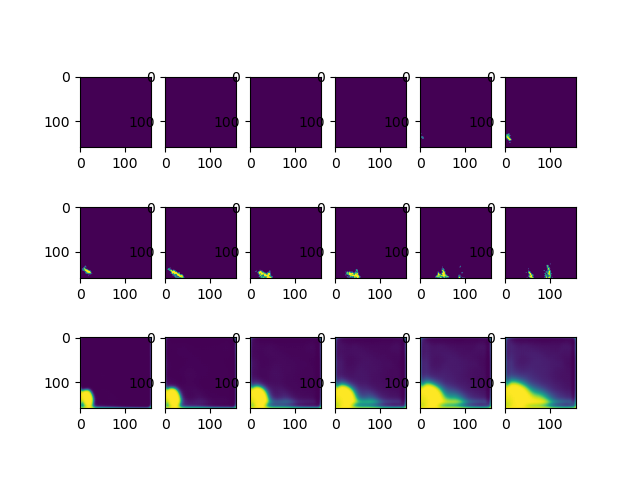

In [28]:
max_ets_model = LightNet(6,8)
max_ets_model.load_state_dict(torch.load("LightNet_model_minFAR.pkl"))
max_ets_model.float()
max_ets_model.to(torch.device("cpu"))
max_ets_model.eval()

X_single, y_single = test_loader.dataset[0]
print(X_single.shape, y_single.shape)



X_single = torch.tensor(X_single).float()
print(X_single.shape)
X_single = X_single.unsqueeze(0)
X_single.to(torch.device("cpu"))

pred = max_ets_model(X_single)
# print(pred)

prev_ax = []
ground_truth_ax = []
predicted_ax = []

fig, axs = plt.subplots(3, 6)

for i in range(6):
    axs[0][i].imshow(X_single[0][i][0])

for i in range(pred.shape[1]):
    axs[1][i].imshow(y_single[i][0])

for i in range(pred.shape[1]):
    axs[2][i].imshow(1/(1+np.exp(-pred.detach().numpy()[0][i][0])))

plt.show()
